In [5]:
from typing import Dict

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras_cv.src.models.stable_diffusion.image_encoder import ImageEncoder
from diffusion_models.stable_diffusion import StableDiffusion
from utils import process_image, augmenter

from visualisation_utils import plot_attention_location, animate_locations
from my_utils import dict_to_disk, dict_from_disk

In [6]:
print(f"GPUs available: ", tf.config.experimental.list_physical_devices('GPU'))
device = tf.test.gpu_device_name()
print(tf.test.gpu_device_name())

GPUs available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


2023-12-06 17:30:12.914132: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-06 17:30:12.914171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-12-06 17:30:12.914335: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-06 17:30:12.914346: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Initialize SD Model

In [7]:
# Inialize Stable Diffusion Model on GPU:0
with tf.device(device):
    image_encoder = ImageEncoder()
    vae = tf.keras.Model(
        image_encoder.input,
        image_encoder.layers[-1].output,
    )
    model = StableDiffusion(img_width=512, img_height=512)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


# Run inference on real image

In [8]:
# Run image through VAE encoder
image_path = "./images/img2.jpeg"

with tf.device(device):
    image = process_image(image_path)
    image = augmenter(image)
    latent = vae(tf.expand_dims(image, axis=0), training=False)

In [9]:
# Dictionary of structure { timestep : { resolution : self-attention map } }
self_attn_dict: Dict[int, Dict[int, np.ndarray]] = { }

In [10]:
# Perform one denoising step
num_timesteps = 10

for timestep in np.arange(0, 1000, 1000 // num_timesteps):
    with tf.device(device):
        weight_64, weight_32, weight_16, weight_8 = model.generate_image(
            batch_size=1,
            latent=latent,
            timestep=timestep,
        )

        # Average over attention heads and store self-attention maps for
        # current time step in dictionary
        self_attn_dict[timestep] = {
            8:  weight_8.mean(axis=(0,1)),
            16: weight_16.mean(axis=(0,1)),
            32: weight_32.mean(axis=(0,1)),
            64: weight_64.mean(axis=(0,1))
        }

2023-12-06 17:30:17.475689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [11]:
# Save self-attention maps to disk
dict_to_disk(
    self_attn_dict=self_attn_dict,
    filename="self_attn_maps/img2"
)

### Show the image

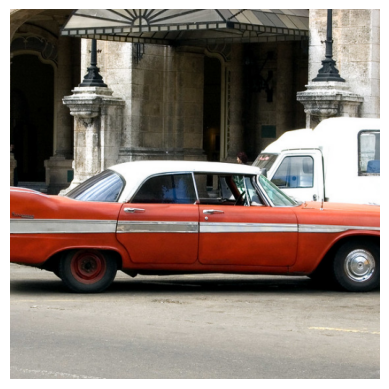

In [12]:
plt.imshow(tf.cast((image + 1.0) * 127.5, tf.int32))
plt.axis('off');

In [ ]:
# # Plotting the input and output image
# fig, axs = plt.subplots(1, 2, figsize=(16, 8))
# axs[0].imshow(input_image[0])
# axs[1].imshow(output_image[0])

# axs[0].set_title("Input image")
# axs[1].set_title("Output image")

# axs[0].axis("off")
# axs[1].axis("off")

# fig.suptitle(f"Time step {timestep}", fontsize=24)
# fig.tight_layout()

# plt.show()

### Visualise the VAE latents

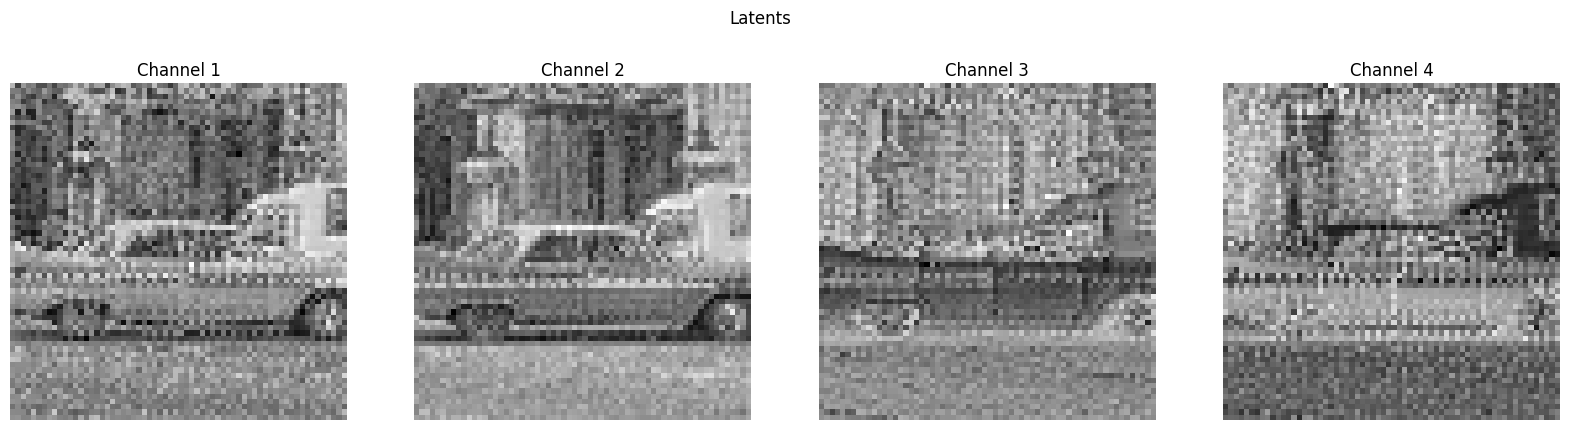

In [13]:
# Plotting the latents
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

# Loop over each channel
for i in range(4):
    channel = latent[0, :, :, i]
    axs[i].imshow(channel, cmap="gray")
    axs[i].set_title(f"Channel {i+1}")
    axs[i].axis("off")  # Hide axis

fig.suptitle("Latents")
plt.show()

In [ ]:
self_attn_dict[0][32].shape

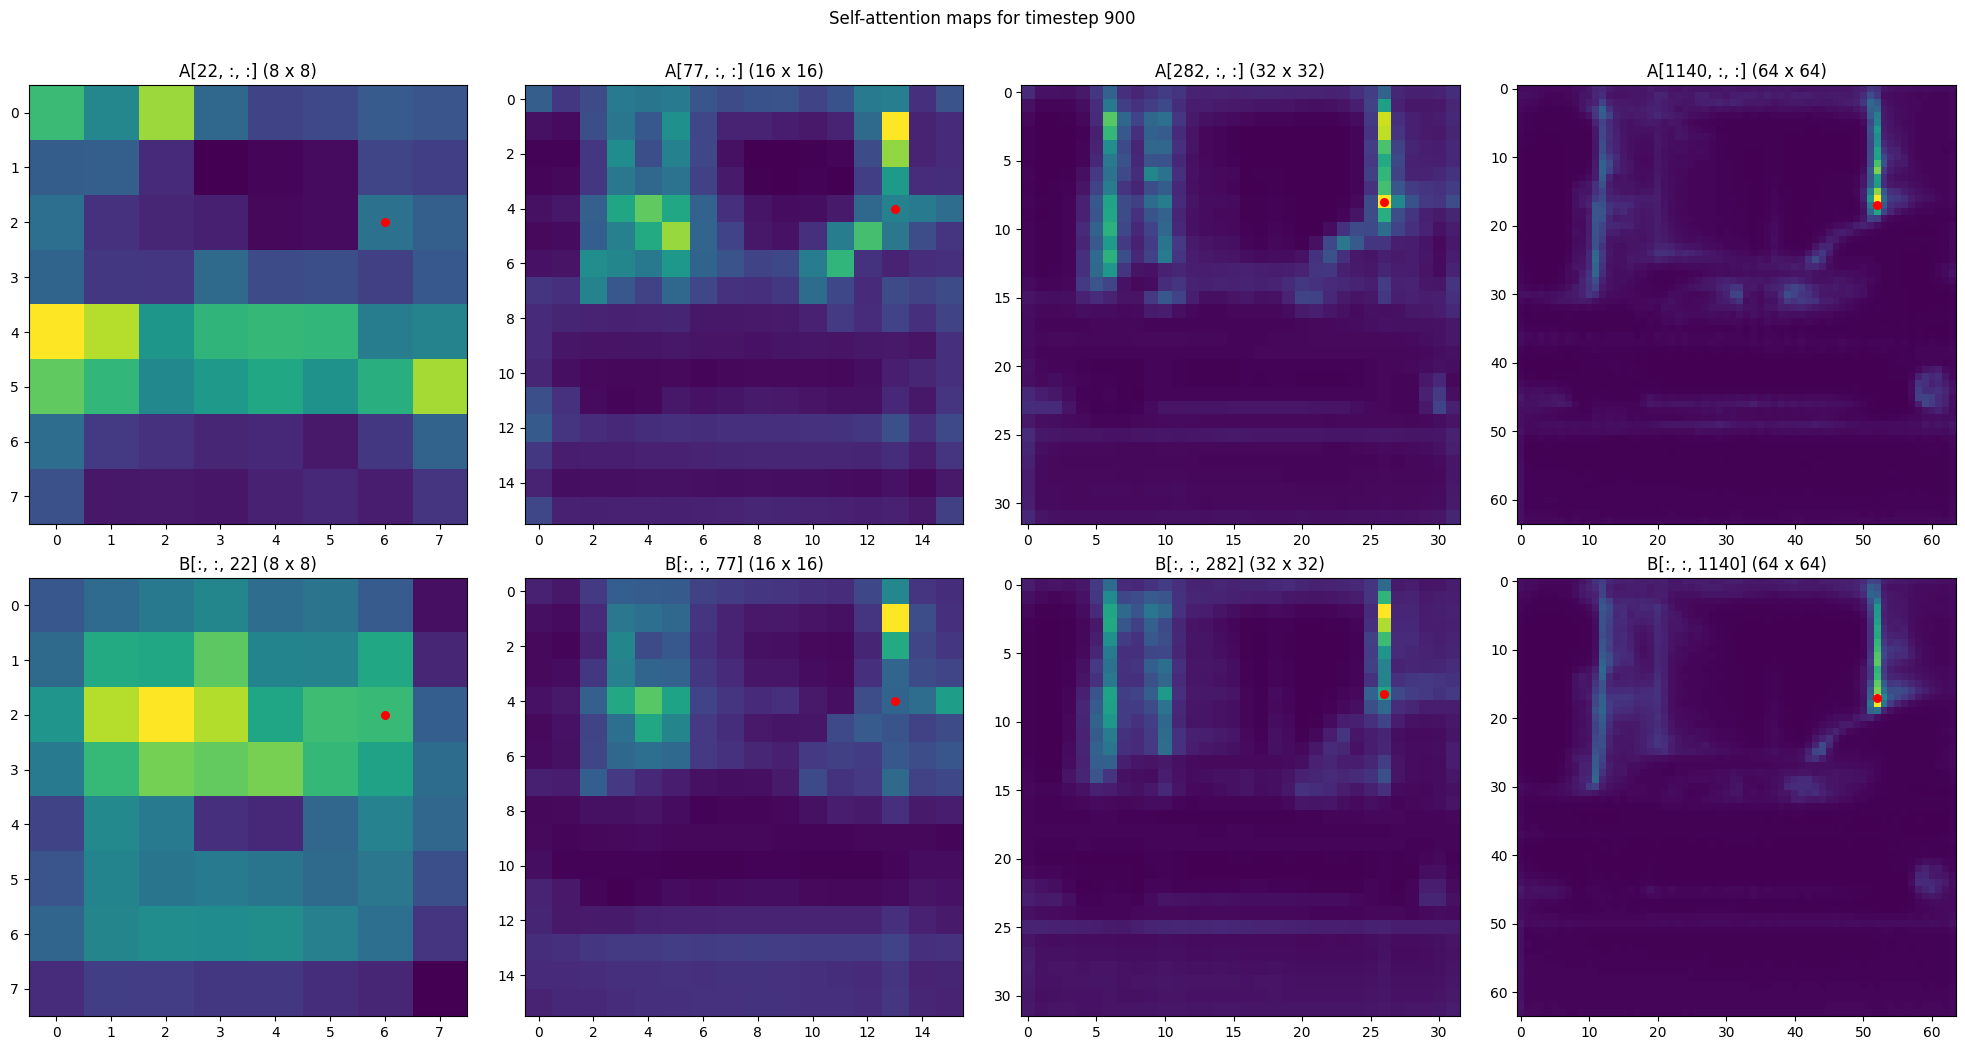

In [15]:
# Change this to a value between 0 and 4095
channel64_idx = 1140
t = 900

# Change `interpolate` to `False` to see raw pixel data
plot_attention_location(
    self_attn_dict[t],
    orig_channel_idx=channel64_idx,
    orig_res=64,
    interpolate=False,
    timestep=timestep
);

The following cell renders the previous $2 \times 4$ plot as an animation that iterates over each pixel in the image.

Saving animation: 100%|██████████| 4096/4096 [20:20<00:00,  3.36it/s]


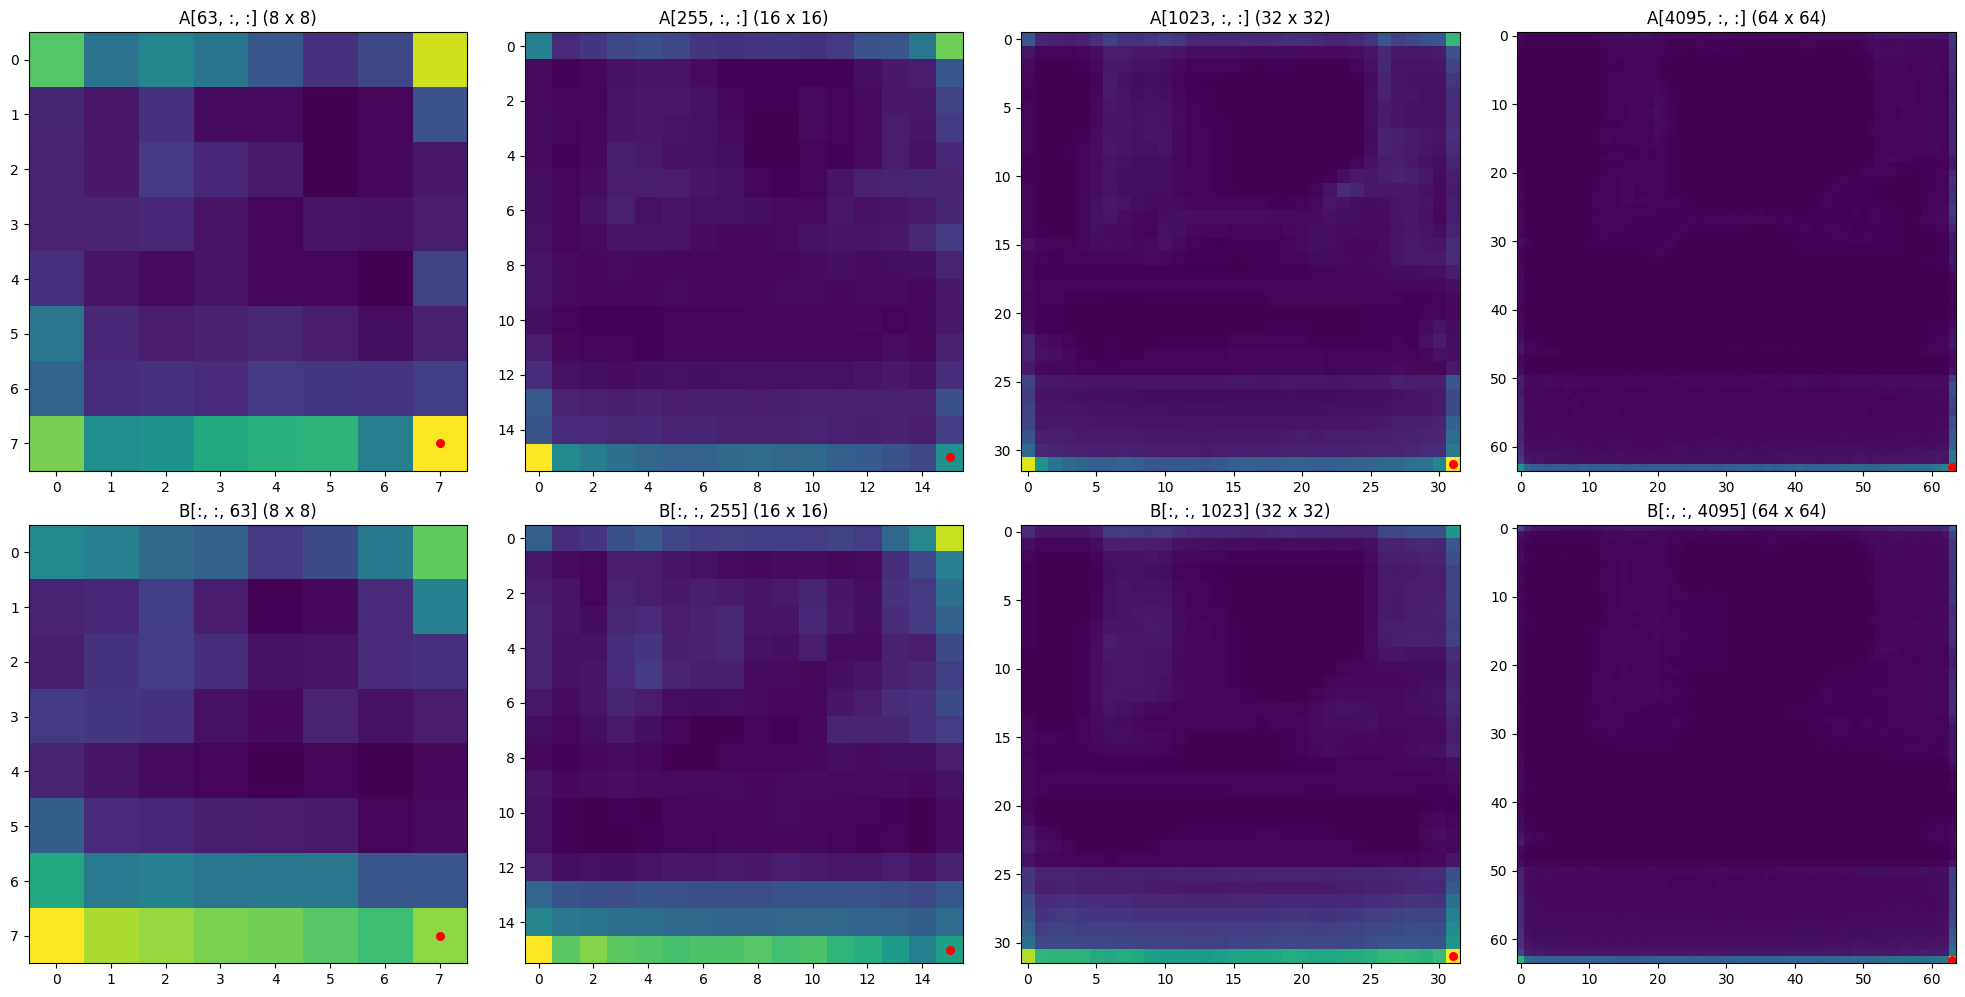

In [17]:
# Uncomment to render animation. This can take a while.
animate_locations(self_attn_dict[t], num_frames=64**2, fps=15, interpolate=False)

In [ ]:
# Example usage
render_attention_animation(
    list(range(0, 1001, 5)),
    orig_channel_idx=1404,
    save_path=f"hockey_loc{1404}_timesteps.mp4",
    fps=30
)

### Compute disk space used for all self-attention maps

In [18]:
bytes_per_float = 4

# 64 x 64
size_64 = 64**4 * num_timesteps * bytes_per_float / 1e9

# 32 x 32
size_32 = 32**4 * num_timesteps * bytes_per_float / 1e9

# 16 x 16
size_16 = 16**4 * num_timesteps * bytes_per_float / 1e9

# 8 x 8
size_8 = 8**4 * num_timesteps * bytes_per_float / 1e9


f"{(size_64 + size_32 + size_16 + size_8):.2f} GB"

'0.72 GB'

### Plot all eight attention heads for a single pixel and time step

In [ ]:
# t = 900

# # Create a 2 x 4 grid of subplots
# fig, axs = plt.subplots(2, 4, figsize=(15, 8))
# fig.suptitle(f"Attention heads for 64 x 64 map at time step {t}", fontsize=20)

# # Loop through heads 0 to 7
# for i in range(8):
#     # Compute row and column for subplot
#     row = i // 4
#     col = i % 4

#     # Plotting each head
#     axs[row, col].imshow(self_attn_dict[t][64][0][i].reshape(64, 64, -1)[:, :, 2700])
#     axs[row, col].set_title(f'Head {i}')

# plt.tight_layout()
# plt.show()